In [18]:
from copy import deepcopy
from dataclasses import dataclass
from typing import Optional, List, Tuple
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

from alns import ALNS
from alns.accept import SimulatedAnnealing
from alns.select import AlphaUCB
from alns.stop import MaxIterations, MaxRuntime

# Set random seed for reproducibility
SEED = 2345
rnd.seed(SEED)

@dataclass
class Data:
    n_jobs: int
    n_machines: int
    bkv: int  # best known value
    processing_times: np.ndarray

    @classmethod
    def from_file(cls, path):
        with open(path, "r") as fi:
            lines = fi.readlines()

            n_jobs, n_machines, _, bkv, _ = [
                int(num) for num in lines[1].split()
            ]
            processing_times = np.genfromtxt(lines[3:], dtype=int)

            return cls(n_jobs, n_machines, bkv, processing_times)


def compute_completion_times(schedule):
    """
    Compute the completion time for each job of the passed-in schedule.
    """
    completion = np.zeros(DATA.processing_times.shape, dtype=int)

    for idx, job in enumerate(schedule):
        for machine in range(DATA.n_machines):
            prev_job = completion[machine, schedule[idx - 1]] if idx > 0 else 0
            prev_machine = completion[machine - 1, job] if machine > 0 else 0
            processing = DATA.processing_times[machine, job]

            completion[machine, job] = max(prev_job, prev_machine) + processing

    return completion


def compute_makespan(schedule):
    """
    Returns the makespan, i.e., the maximum completion time.
    """
    return compute_completion_times(schedule)[-1, schedule[-1]]


def plot(schedule, name):
    """
    Plots a Gantt chart of the schedule for the permutation flow shop problem.
    """
    n_machines, n_jobs = DATA.processing_times.shape

    completion = compute_completion_times(schedule)
    start = completion - DATA.processing_times

    # Plot each job using its start and completion time
    cmap = plt.colormaps["rainbow"].resampled(n_jobs)
    machines, length, start_job, job_colors = zip(
        *[
            (i, DATA.processing_times[i, j], start[i, j], cmap(j - 1))
            for i in range(n_machines)
            for j in range(n_jobs)
        ]
    )

    _, ax = plt.subplots(1, figsize=(12, 6))
    ax.barh(machines, length, left=start_job, color=job_colors)

    ax.set_title(f"{name}\n Makespan: {compute_makespan(schedule)}")
    ax.set_ylabel(f"Machine")
    ax.set_xlabel(f"Completion time")
    ax.set_yticks(range(DATA.n_machines))
    ax.set_yticklabels(range(1, DATA.n_machines + 1))
    ax.invert_yaxis()

    plt.show()


class Solution:
    def __init__(
        self, schedule: List[int], unassigned: Optional[List[int]] = None
    ):
        self.schedule = schedule
        self.unassigned = unassigned if unassigned is not None else []

    def objective(self):
        return compute_makespan(self.schedule)

    def insert(self, job: int, idx: int):
        self.schedule.insert(idx, job)

    def opt_insert(self, job: int):
        """
        Optimally insert the job in the current schedule.
        """
        idcs_costs = all_insert_cost(self.schedule, job)
        idx, _ = min(idcs_costs, key=lambda idx_cost: idx_cost[1])
        self.insert(job, idx)

    def remove(self, job: int):
        self.schedule.remove(job)


def all_insert_cost(schedule: List[int], job: int) -> List[Tuple[int, float]]:
    """
    Computes all partial makespans when inserting a job in the schedule.
    O(nm) using Taillard's acceleration. Returns a list of tuples of the
    insertion index and the resulting makespan.

    [1] Taillard, E. (1990). Some efficient heuristic methods for the
    flow shop sequencing problem. European Journal of Operational Research,
    47(1), 65-74.
    """
    k = len(schedule) + 1
    m = DATA.processing_times.shape[0]
    p = DATA.processing_times

    # Earliest completion of schedule[j] on machine i before insertion
    e = np.zeros((m + 1, k))
    for j in range(k - 1):
        for i in range(m):
            e[i, j] = max(e[i, j - 1], e[i - 1, j]) + p[i, schedule[j]]

    # Duration between starting time and final makespan
    q = np.zeros((m + 1, k))
    for j in range(k - 2, -1, -1):
        for i in range(m - 1, -1, -1):
            q[i, j] = max(q[i + 1, j], q[i, j + 1]) + p[i, schedule[j]]

    # Earliest relative completion time
    f = np.zeros((m + 1, k))
    for l in range(k):
        for i in range(m):
            f[i, l] = max(f[i - 1, l], e[i, l - 1]) + p[i, job]

    # Partial makespan; drop the last (dummy) row of q
    M = np.max(f + q, axis=0)

    return [(idx, M[idx]) for idx in np.argsort(M)]


def random_removal(state: Solution, rng, n_remove=2) -> Solution:
    """
    Randomly remove a number jobs from the solution.
    """
    destroyed = deepcopy(state)

    for job in rng.choice(DATA.n_jobs, n_remove, replace=False):
        destroyed.unassigned.append(job)
        destroyed.schedule.remove(job)

    return destroyed


def adjacent_removal(state: Solution, rng, n_remove=2) -> Solution:
    """
    Randomly remove a number adjacent jobs from the solution.
    """
    destroyed = deepcopy(state)

    start = rng.integers(DATA.n_jobs - n_remove)
    jobs_to_remove = [state.schedule[start + idx] for idx in range(n_remove)]

    for job in jobs_to_remove:
        destroyed.unassigned.append(job)
        destroyed.schedule.remove(job)

    return destroyed


def greedy_repair(state: Solution, rng, **kwargs) -> Solution:
    """
    Greedily insert the unassigned jobs back into the schedule. The jobs are
    inserted in non-decreasing order of total processing times.
    """
    state.unassigned.sort(key=lambda j: sum(DATA.processing_times[:, j]))

    while len(state.unassigned) != 0:
        job = state.unassigned.pop()  # largest total processing time first
        state.opt_insert(job)

    return state


def local_search(solution: Solution, **kwargs):
    """
    Improves the current solution in-place using the insertion neighborhood.
    A random job is selected and put in the best new position. This continues
    until relocating any of the jobs does not lead to an improving move.
    """
    improved = True

    while improved:
        improved = False
        current = solution.objective()

        for job in rnd.choice(
            solution.schedule, len(solution.schedule), replace=False
        ):
            solution.remove(job)
            solution.opt_insert(job)

            if solution.objective() < current:
                improved = True
                current = solution.objective()
                break


def greedy_repair_then_local_search(state: Solution, rng, **kwargs):
    """
    Greedily insert the unassigned jobs back into the schedule (using NEH
    ordering). Apply local search afterwards.
    """
    state = greedy_repair(state, rng, **kwargs)
    local_search(state, **kwargs)
    return state


def NEH(processing_times: np.ndarray) -> Solution:
    """
    Schedules jobs in decreasing order of the total processing times.

    [1] Nawaz, M., Enscore Jr, E. E., & Ham, I. (1983). A heuristic algorithm
    for the m-machine, n-job flow-shop sequencing problem. Omega, 11(1), 91-95.
    """
    largest_first = np.argsort(processing_times.sum(axis=0)).tolist()[::-1]
    solution = Solution([largest_first.pop(0)], [])

    for job in largest_first:
        solution.opt_insert(job)

    return solution


In [19]:
def local_search_repair(state: Solution, rng, **kwargs) -> Solution:
    """
    Enhanced repair operator that reinserts unassigned jobs using a local search.
    
    Steps:
      1. Identify the bottleneck machine (with highest total processing time).
      2. Sort unassigned jobs in descending order by their processing time on that machine.
      3. For each unassigned job:
         a. Compute all insertion positions (using Taillard's acceleration via all_insert_cost).
         b. Insert the job at the best position.
         c. Perform a local search (by swapping with neighbors) to check for further improvements.
    """
    # Identify the bottleneck machine (machine with maximum total processing time)
    total_pt = np.sum(DATA.processing_times, axis=1)
    bottleneck = int(np.argmax(total_pt))
    
    # Sort unassigned jobs: those with higher processing time on the bottleneck machine get priority.
    state.unassigned.sort(key=lambda j: DATA.processing_times[bottleneck, j], reverse=True)
    
    # Reinsert each unassigned job
    while state.unassigned:
        # Pop the job with highest priority
        job = state.unassigned.pop(0)
        
        # Get the makespan for all possible insertion positions using Taillard's method.
        insertion_options = all_insert_cost(state.schedule, job)
        best_index, best_cost = min(insertion_options, key=lambda x: x[1])
        
        # Insert the job at the best found position.
        state.schedule.insert(best_index, job)
        
        # --- Local Search Phase ---
        # Try to further improve the schedule by swapping the inserted job with its neighbors.
        improved = True
        while improved:
            improved = False
            current_cost = compute_makespan(state.schedule)
            index = state.schedule.index(job)
            
            # Try moving the job one position to the left.
            if index > 0:
                state.schedule[index], state.schedule[index - 1] = state.schedule[index - 1], state.schedule[index]
                new_cost = compute_makespan(state.schedule)
                if new_cost < current_cost:
                    improved = True
                    current_cost = new_cost  # accept the move
                else:
                    # Revert the swap if no improvement
                    state.schedule[index], state.schedule[index - 1] = state.schedule[index - 1], state.schedule[index]
            
            # Try moving the job one position to the right.
            index = state.schedule.index(job)  # update index (in case it changed)
            if index < len(state.schedule) - 1:
                state.schedule[index], state.schedule[index + 1] = state.schedule[index + 1], state.schedule[index]
                new_cost = compute_makespan(state.schedule)
                if new_cost < current_cost:
                    improved = True
                    current_cost = new_cost
                else:
                    # Revert if no improvement
                    state.schedule[index], state.schedule[index + 1] = state.schedule[index + 1], state.schedule[index]
        # --- End Local Search Phase ---
    
    return state

In [20]:
from copy import deepcopy
from typing import List, Optional, Tuple
import numpy as np
import numpy.random as Generator # Assuming ALNS passes a numpy generator

# -------------------------------------------------------------

def get_critical_path(schedule: List[int]) -> List[int]:
    """
    Trace the critical path in the current schedule.
    Starting from the last machine and the last job,
    move backwards by choosing the predecessor that contributed to
    the completion time (using the recurrence in compute_completion_times).

    Returns a list of unique jobs on the critical path.
    """
    comp = compute_completion_times(schedule)
    m = DATA.n_machines
    k = len(schedule)

    # Handle empty schedule case
    if k == 0:
        return []

    cp_jobs = set()  # to store jobs on the critical path (unique)
    i = m - 1         # start at the last machine
    j = k - 1         # start at the last job in the schedule
    cp_jobs.add(schedule[j])

    # Trace back until we reach the beginning
    while i > 0 or j > 0:
        # Determine the completion time of the current operation (i, j)
        current_comp_time = comp[i, schedule[j]]
        current_proc_time = DATA.processing_times[i, schedule[j]]

        # Check if the bottleneck was the previous job on the same machine
        prev_job_comp = comp[i, schedule[j-1]] if j > 0 else 0
        is_from_prev_job = (j > 0 and current_comp_time == prev_job_comp + current_proc_time)

        # Check if the bottleneck was the same job on the previous machine
        prev_mach_comp = comp[i-1, schedule[j]] if i > 0 else 0
        is_from_prev_mach = (i > 0 and current_comp_time == prev_mach_comp + current_proc_time)

        # Decide which way to move: prioritize moving left if possible and it explains the time
        # If moving left doesn't explain the time, or we can't move left, we must move up.
        if is_from_prev_job and (not is_from_prev_mach or prev_job_comp >= prev_mach_comp):
             j -= 1
        elif is_from_prev_mach: # Must move up if we can
             i -= 1
        elif j > 0: # Fallback if only previous job is possible (e.g., first machine)
             j -= 1
        elif i > 0: # Fallback if only previous machine is possible (e.g., first job)
             i -= 1
        else: # Should not happen if loop condition is correct
            break

        cp_jobs.add(schedule[j]) # Add the job at the new (i, j) position

    return list(cp_jobs)


def critical_destroy(state: Solution, rng: Generator, n_remove: int = 2) -> Solution:
    """
    Destroy operator that removes jobs contributing most to the makespan
    by targeting jobs on the critical path.
    """
    # Create a deep copy so we don't modify the original solution.
    destroyed = deepcopy(state)

    # Handle cases with few jobs in the schedule
    if len(destroyed.schedule) <= n_remove:
        destroyed.unassigned.extend(destroyed.schedule)
        destroyed.schedule = []
        return destroyed

    # Identify the jobs on the critical path.
    cp_jobs = get_critical_path(destroyed.schedule)

    jobs_to_remove = []

    # If there are enough critical jobs, select from them.
    # Optional refinement: sort critical jobs by processing time on the last machine.
    if len(cp_jobs) >= n_remove:
        # Simple random selection from critical path:
        # indices_to_remove = rng.choice(len(cp_jobs), n_remove, replace=False)
        # jobs_to_remove = [cp_jobs[i] for i in indices_to_remove]

        # Refined: Remove critical jobs with highest processing time on last machine
        cp_jobs_sorted = sorted(cp_jobs, key=lambda j: DATA.processing_times[DATA.n_machines - 1, j], reverse=True)
        jobs_to_remove = cp_jobs_sorted[:n_remove]

    else:
        # Otherwise, remove all critical path jobs and then select additional jobs at random.
        jobs_to_remove = cp_jobs.copy()
        remaining_jobs = [j for j in destroyed.schedule if j not in jobs_to_remove]
        # Ensure we don't try to remove more jobs than available
        num_additional_needed = min(n_remove - len(cp_jobs), len(remaining_jobs))
        if num_additional_needed > 0:
             additional = rng.choice(remaining_jobs, num_additional_needed, replace=False)
             jobs_to_remove.extend(additional)

    # Remove the selected jobs from the schedule and add them to the unassigned list.
    for job in jobs_to_remove:
        # Need to handle potential ValueError if job was already removed (e.g. if n_remove > |cp_jobs|)
        if job in destroyed.schedule:
            destroyed.unassigned.append(job)
            destroyed.schedule.remove(job) # Note: remove is O(N), could optimize if needed

    return destroyed

In [21]:
def bottleneck_destroy(state: Solution, rng, n_remove=2) -> Solution:
    """
    Destroy operator that targets jobs with high processing times on bottleneck machines.
    """
    destroyed = deepcopy(state)
    
    # Find the bottleneck machine
    machine_loads = np.sum(DATA.processing_times, axis=1)
    bottleneck_machine = np.argmax(machine_loads)
    
    # Sort and remove jobs with highest processing times on bottleneck
    jobs_sorted = sorted(
        destroyed.schedule, 
        key=lambda j: DATA.processing_times[bottleneck_machine, j],
        reverse=True
    )
    
    for job in jobs_sorted[:n_remove]:
        destroyed.unassigned.append(job)
        destroyed.schedule.remove(job)
    
    return destroyed

def regret_based_repair(state: Solution, rng, **kwargs) -> Solution:
    """
    Repair operator that uses regret-based insertion.
    """
    repaired = deepcopy(state)
    
    while repaired.unassigned:
        max_regret = -1
        best_job = None
        best_position = None
        
        # Calculate regret for each unassigned job
        for job in repaired.unassigned:
            positions_costs = all_insert_cost(repaired.schedule, job)
            positions_costs.sort(key=lambda x: x[1])
            
            # Calculate regret (difference between best and second-best position)
            if len(positions_costs) == 1:
                regret = float('inf')
            else:
                regret = positions_costs[1][1] - positions_costs[0][1]
            
            if regret > max_regret:
                max_regret = regret
                best_job = job
                best_position = positions_costs[0][0]
        
        # Insert job with highest regret
        repaired.unassigned.remove(best_job)
        repaired.schedule.insert(best_position, best_job)
    
    return repaired

In [22]:
# def critical_job_removal(state: Solution, rng, n_remove=2) -> Solution:
#     """
#     Remove jobs with the longest total processing times from the schedule.
#     These jobs are often critical for the makespan.
#     """
#     destroyed = deepcopy(state)

#     # Calculate total processing time for each job in the current schedule
#     job_total_times = [
#         (job, DATA.processing_times[:, job].sum())
#         for job in destroyed.schedule
#     ]

#     # Sort jobs by total processing time (descending)
#     job_total_times.sort(key=lambda item: item[1], reverse=True)

#     # Select the top n_remove jobs with the longest processing times
#     jobs_to_remove = [job for job, time in job_total_times[:n_remove]]

#     # Remove selected jobs and add them to unassigned
#     for job in jobs_to_remove:
#         destroyed.schedule.remove(job)
#         destroyed.unassigned.append(job)

#     return destroyed

# def min_idle_time_insertion_repair(state: Solution, rng, **kwargs) -> Solution:
#     """
#     Repairs the schedule by inserting unassigned jobs.
#     Jobs are inserted in increasing order of their total processing time,
#     aiming to fill smaller gaps first. Optimal insertion position is found
#     using Taillard's acceleration for each job.
#     """
#     # Calculate total processing times for unassigned jobs
#     unassigned_times = [
#         (job, DATA.processing_times[:, job].sum())
#         for job in state.unassigned
#     ]

#     # Sort unassigned jobs by total processing time (ascending)
#     unassigned_times.sort(key=lambda item: item[1])

#     # Insert jobs one by one using optimal insertion
#     for job, _ in unassigned_times:
#         state.opt_insert(job)  # Finds best position and inserts

#     # Clear the unassigned list as all jobs are inserted
#     state.unassigned = []

#     return state

In [23]:
# --- New Custom Destroy Operators ---
# GEMINI

def worst_job_removal(state: Solution, rng, n_remove=2, **kwargs) -> Solution:
    """
    Removes jobs that contribute most to the makespan.
    It identifies jobs based on their completion time on the last machine.
    Jobs finishing later are considered 'worse'.
    """
    destroyed = deepcopy(state)
    actual_remove = min(n_remove, len(destroyed.schedule))
    if actual_remove <= 0:
        return destroyed

    completion_times = compute_completion_times(destroyed.schedule)
    last_machine_completion = completion_times[DATA.n_machines - 1, :] # Completion time on last machine for all jobs

    # Get completion times only for jobs currently in the schedule
    scheduled_job_completions = {job: last_machine_completion[job] for job in destroyed.schedule}

    # Sort jobs in the schedule by their completion time on the last machine (descending)
    sorted_jobs = sorted(destroyed.schedule, key=lambda job: scheduled_job_completions[job], reverse=True)

    # Select the worst jobs to remove
    jobs_to_remove = sorted_jobs[:actual_remove]

    for job in jobs_to_remove:
        destroyed.unassigned.append(job)
        destroyed.schedule.remove(job) # remove preserves order of remaining jobs

    return destroyed


def related_job_removal(state: Solution, rng, n_remove=2, **kwargs) -> Solution:
    """
    Removes jobs with similar processing time profiles.
    Picks a random job and removes its most similar neighbors based on
    Euclidean distance of processing time vectors.
    """
    destroyed = deepcopy(state)
    actual_remove = min(n_remove, len(destroyed.schedule))
    if actual_remove <= 1: # Need at least 2 jobs to find related ones
        # Fallback to random removal if not enough jobs or n_remove is too small
        return random_removal(state, rng, n_remove=actual_remove, **kwargs)

    # Pick a random job currently in the schedule
    pivot_job = rng.choice(destroyed.schedule)
    pivot_proc_times = DATA.processing_times[:, pivot_job]

    similarities = {}
    for job in destroyed.schedule:
        if job == pivot_job:
            continue
        other_proc_times = DATA.processing_times[:, job]
        # Calculate Euclidean distance (lower is more similar)
        distance = np.linalg.norm(pivot_proc_times - other_proc_times)
        similarities[job] = distance

    # Sort other jobs by similarity (ascending distance)
    sorted_similar_jobs = sorted(similarities.keys(), key=lambda job: similarities[job])

    # Select the pivot job and its (n_remove - 1) most similar jobs
    jobs_to_remove = [pivot_job] + sorted_similar_jobs[:actual_remove - 1]

    for job in jobs_to_remove:
        destroyed.unassigned.append(job)
        destroyed.schedule.remove(job)

    return destroyed


# --- New Custom Repair Operators ---

def regret_repair(state: Solution, rng, k_regret=3, **kwargs) -> Solution:
    """
    Repairs a solution by inserting jobs based on a regret heuristic.
    It prioritizes inserting jobs that have the largest difference (regret)
    between their best insertion cost and their k-th best insertion cost.
    This focuses on jobs with fewer good placement options.
    """
    while len(state.unassigned) != 0:
        regrets = {}
        best_insertions = {}

        for job in state.unassigned:
            # Find all insertion costs/positions for the current job
            insert_costs = all_insert_cost(state.schedule, job) # Returns sorted list [(idx, cost), ...]

            if len(insert_costs) == 0: # Should not happen if schedule is not full
                 continue
            elif len(insert_costs) == 1:
                # Only one possible insertion place
                best_cost = insert_costs[0][1]
                kth_best_cost = best_cost # No other options, regret is 0
                best_insertions[job] = insert_costs[0] # Store (idx, cost)
            else:
                # Determine regret based on k_regret parameter
                k = min(k_regret, len(insert_costs))
                best_cost = insert_costs[0][1]
                kth_best_cost = insert_costs[k-1][1]
                best_insertions[job] = insert_costs[0] # Store (idx, cost)

            regrets[job] = kth_best_cost - best_cost # Higher regret means fewer good options

        if not regrets: # No jobs left to calculate regret for
            break

        # Select the job with the highest regret
        job_to_insert = max(regrets.keys(), key=lambda job: regrets[job])

        # Insert the selected job at its best position
        best_idx, _ = best_insertions[job_to_insert]
        state.insert(job_to_insert, best_idx)
        state.unassigned.remove(job_to_insert)

    return state


def min_idle_proxy_repair(state: Solution, rng, k_best=5, **kwargs) -> Solution:
    """
    Repairs a solution by inserting jobs prioritizing minimal idle time proxy.
    For each job, it considers the k best insertion positions (by makespan)
    and selects the one that minimizes the start time of the inserted job
    on the last machine (as a proxy for reducing downstream idle time).
    Jobs are considered in NEH order (highest total processing time first).
    """
    state.unassigned.sort(key=lambda j: sum(DATA.processing_times[:, j]), reverse=True)

    while len(state.unassigned) != 0:
        job_to_insert = state.unassigned.pop()

        insert_costs = all_insert_cost(state.schedule, job_to_insert) # Sorted [(idx, cost), ...]

        if not insert_costs:
            # Handle case where insertion might not be possible (e.g., schedule full - should not happen)
            # Or maybe insert randomly if no costs found? Or skip? For now, just continue.
             continue

        best_insertion_idx = -1
        min_proxy_value = float('inf')
        min_proxy_makespan = float('inf')

        # Consider top k potential insertion positions based on makespan
        num_candidates = min(k_best, len(insert_costs))
        for i in range(num_candidates):
            idx, makespan_cost = insert_costs[i]

            # Create a temporary schedule with the job inserted
            temp_schedule = state.schedule[:idx] + [job_to_insert] + state.schedule[idx:]

            # Calculate completion times for the temporary schedule
            temp_completion = compute_completion_times(temp_schedule)
            
            # Proxy: Start time of the inserted job on the last machine
            start_time_last_machine = (temp_completion[DATA.n_machines - 1, job_to_insert] -
                                       DATA.processing_times[DATA.n_machines - 1, job_to_insert])

            # Choose based on proxy, tie-break with makespan
            if start_time_last_machine < min_proxy_value:
                min_proxy_value = start_time_last_machine
                min_proxy_makespan = makespan_cost
                best_insertion_idx = idx
            elif start_time_last_machine == min_proxy_value and makespan_cost < min_proxy_makespan:
                 min_proxy_makespan = makespan_cost
                 best_insertion_idx = idx


        # If we didn't find a best index (e.g., only one option considered and failed?)
        # Fallback to the absolute best makespan position
        if best_insertion_idx == -1:
             best_insertion_idx = insert_costs[0][0]


        # Perform the chosen insertion
        state.insert(job_to_insert, best_insertion_idx)
        # Job already popped from unassigned list

    return state


In [24]:
# CLAUDE
def critical_path_removal(state: Solution, rng, n_remove=2) -> Solution:
    """
    Remove jobs that lie on the critical path of the schedule.
    The critical path consists of operations that directly contribute to the makespan.
    """
    destroyed = deepcopy(state)
    schedule = destroyed.schedule
    
    # Check for empty schedule
    if not schedule:
        return destroyed
    
    # Calculate completion times for each job on each machine
    completion_times = compute_completion_times(schedule)
    m = DATA.n_machines - 1
    
    # Identify jobs on the critical path by backtracking from the last machine
    critical_jobs = []
    current_job_idx = len(schedule) - 1
    current_job = schedule[current_job_idx]
    
    while current_job_idx >= 0 and len(critical_jobs) < n_remove:
        # Add the current job to critical jobs
        critical_jobs.append(schedule[current_job_idx])
        
        # Find the previous job on the critical path
        if current_job_idx > 0 and m > 0:
            prev_job_idx = current_job_idx - 1
            prev_job = schedule[prev_job_idx]
            
            # If previous job on same machine determined the start time
            if completion_times[m, prev_job] == completion_times[m, current_job] - DATA.processing_times[m, current_job]:
                current_job_idx = prev_job_idx
                current_job = prev_job
            # Otherwise, same job on previous machine determined the start time
            else:
                m -= 1
        else:
            break
    
    # Make sure jobs are unique in the list to avoid trying to remove the same job twice
    critical_jobs = list(dict.fromkeys(critical_jobs))
    
    # Randomly select from critical jobs if we have more than n_remove
    to_remove = rng.choice(critical_jobs, min(n_remove, len(critical_jobs)), replace=False)
    
    # Keep track of already removed jobs to avoid trying to remove the same job twice
    already_removed = set()
    
    for job in to_remove:
        if job in already_removed:
            continue
            
        if job in destroyed.schedule:  # Check if job is still in schedule before removing
            destroyed.unassigned.append(job)
            destroyed.schedule.remove(job)
            already_removed.add(job)
        
    return destroyed


def bottleneck_machine_removal(state: Solution, rng, n_remove=2) -> Solution:
    """
    Remove jobs that have high processing times on bottleneck machines.
    Bottleneck machines are the ones with highest average processing time.
    """
    destroyed = deepcopy(state)
    
    # Identify bottleneck machine (highest average processing time)
    avg_processing_times = DATA.processing_times.mean(axis=1)
    bottleneck_machine = np.argmax(avg_processing_times)
    
    # Sort jobs by their processing time on the bottleneck machine
    jobs_by_bottleneck_time = sorted(
        destroyed.schedule, 
        key=lambda job: -DATA.processing_times[bottleneck_machine, job]
    )
    
    # Select top n_remove jobs with highest processing time on bottleneck
    to_remove = jobs_by_bottleneck_time[:n_remove]
    
    for job in to_remove:
        destroyed.unassigned.append(job)
        destroyed.schedule.remove(job)
        
    return destroyed


def makespan_contribution_removal(state: Solution, rng, n_remove=2) -> Solution:
    """
    Remove jobs that contribute most to the makespan by evaluating
    the makespan improvement when each job is removed.
    """
    destroyed = deepcopy(state)
    original_makespan = compute_makespan(destroyed.schedule)
    
    # Calculate makespan contribution for each job
    contributions = []
    for job in destroyed.schedule:
        # Create a temporary schedule without this job
        temp_schedule = [j for j in destroyed.schedule if j != job]
        new_makespan = compute_makespan(temp_schedule) 
        
        # Calculate contribution as reduction in makespan
        contribution = original_makespan - new_makespan
        contributions.append((job, contribution))
    
    # Sort by contribution (highest first)
    contributions.sort(key=lambda x: -x[1])
    
    # Select top n_remove jobs with highest contribution
    to_remove = [job for job, _ in contributions[:n_remove]]
    
    for job in to_remove:
        destroyed.unassigned.append(job)
        destroyed.schedule.remove(job)
        
    return destroyed


def block_removal(state: Solution, rng, n_remove=2, block_size=2) -> Solution:
    """
    Remove multiple blocks of adjacent jobs.
    This generalizes adjacent_removal by allowing multiple non-contiguous blocks.
    """
    destroyed = deepcopy(state)
    jobs_to_remove = []
    
    # Calculate how many blocks to remove
    n_blocks = max(1, n_remove // block_size)
    remaining = n_remove
    
    for _ in range(n_blocks):
        # Size of this block (last block might be smaller)
        this_block_size = min(block_size, remaining)
        
        # If schedule is too short for another block, break
        if len(destroyed.schedule) <= this_block_size:
            break
            
        # Select random starting position
        start = rng.integers(len(destroyed.schedule) - this_block_size + 1)
        
        # Add jobs from this block
        for i in range(this_block_size):
            job = destroyed.schedule[start + i]
            if job not in jobs_to_remove:  # Avoid duplicates
                jobs_to_remove.append(job)
                remaining -= 1
    
    # Remove the selected jobs
    for job in jobs_to_remove:
        destroyed.unassigned.append(job)
        destroyed.schedule.remove(job)
        
    return destroyed


def worst_position_removal(state: Solution, rng, n_remove=2) -> Solution:
    """
    Remove jobs that, if placed in their optimal position, would most improve the makespan.
    This identifies jobs that are currently in a suboptimal position.
    """
    destroyed = deepcopy(state)
    improvements = []
    
    # For each job, calculate makespan improvement if it were optimally repositioned
    for job in state.schedule:  # Use original state to iterate through jobs
        # Skip if schedule is too short
        if len(destroyed.schedule) <= 1:
            break
            
        # Create a temporary schedule without this job
        temp_schedule = [j for j in destroyed.schedule if j != job]
        current_makespan = compute_makespan(temp_schedule)
        
        # Find optimal position for reinsertion
        best_makespan = float('inf')
        for pos in range(len(temp_schedule) + 1):
            temp_schedule_with_job = temp_schedule.copy()
            temp_schedule_with_job.insert(pos, job)
            makespan = compute_makespan(temp_schedule_with_job)
            if makespan < best_makespan:
                best_makespan = makespan
        
        # Calculate improvement
        improvement = current_makespan - best_makespan
        improvements.append((job, improvement))
    
    # Sort by improvement (highest first)
    improvements.sort(key=lambda x: -x[1])
    
    # Select top n_remove jobs with highest improvement potential
    to_remove = [job for job, _ in improvements[:min(n_remove, len(improvements))]]
    
    # Create fresh destroyed state
    destroyed = deepcopy(state)
    # Keep track of already removed jobs
    already_removed = set()
    
    for job in to_remove:
        if job not in already_removed and job in destroyed.schedule:
            destroyed.unassigned.append(job)
            destroyed.schedule.remove(job)
            already_removed.add(job)
        
    return destroyed

In [29]:
# CLAUDE
def least_processing_time_repair(state: Solution, rng, **kwargs) -> Solution:
    """
    Insert jobs in increasing order of total processing times (opposite of NEH).
    This can be effective for exploring different areas of the solution space.
    """
    # Sort unassigned jobs by total processing time (ascending)
    state.unassigned.sort(key=lambda j: sum(DATA.processing_times[:, j]))
    
    # Insert each job in its best position
    while len(state.unassigned) != 0:
        job = state.unassigned.pop(0)  # Smallest processing time first
        state.opt_insert(job)
    
    return state


def regret_insertion_repair(state: Solution, rng, **kwargs) -> Solution:
    """
    Insert jobs that would have the highest regret if not inserted in their best position.
    Regret is defined as the difference between best and second-best insertion positions.
    """
    while len(state.unassigned) != 0:
        max_regret = -float('inf')
        max_regret_job = None
        max_regret_idx = None
        
        # For each unassigned job, calculate regret
        for job in state.unassigned:
            # Get all insertion positions and their costs
            idcs_costs = all_insert_cost(state.schedule, job)
            
            # If we have at least 2 positions
            if len(idcs_costs) >= 2:
                # Calculate regret (difference between best and second best)
                best_cost = idcs_costs[0][1]
                second_best_cost = idcs_costs[1][1]
                regret = second_best_cost - best_cost
                
                if regret > max_regret:
                    max_regret = regret
                    max_regret_job = job
                    max_regret_idx = idcs_costs[0][0]  # Best position index
            else:
                # If only one position, use it directly
                max_regret_job = job
                max_regret_idx = idcs_costs[0][0]
        
        # If we found a job with regret
        if max_regret_job is not None:
            state.unassigned.remove(max_regret_job)
            state.insert(max_regret_job, max_regret_idx)
        else:
            # Fallback to greedy insertion for remaining jobs
            job = state.unassigned.pop(0)
            state.opt_insert(job)
    
    return state


def bottleneck_based_repair(state: Solution, rng, **kwargs) -> Solution:
    """
    Prioritize jobs based on their impact on bottleneck machines.
    Jobs with high processing times on bottleneck machines are inserted first.
    """
    # Identify bottleneck machines (highest average processing time)
    avg_machine_times = DATA.processing_times.mean(axis=1)
    machine_ranks = np.argsort(-avg_machine_times)  # Sort in descending order
    
    # Calculate a score for each job based on bottleneck impact
    job_scores = []
    for job in state.unassigned:
        # Weight processing times by machine bottleneck rank
        score = sum(DATA.processing_times[m, job] * (DATA.n_machines - i) 
                    for i, m in enumerate(machine_ranks))
        job_scores.append((job, score))
    
    # Sort by score (descending)
    job_scores.sort(key=lambda x: -x[1])
    
    # Create a new unassigned list ordered by bottleneck impact
    state.unassigned = [job for job, _ in job_scores]
    
    # Insert each job in its best position
    while len(state.unassigned) != 0:
        job = state.unassigned.pop(0)
        state.opt_insert(job)
    
    return state


def random_insert_with_local_search(state: Solution, rng, **kwargs) -> Solution:
    """
    Randomly insert jobs followed by an intensification phase using local search.
    This combines exploration (random insertion) with exploitation (local search).
    """
    # Make a copy of unassigned jobs before shuffling
    jobs_to_insert = list(state.unassigned)
    rng.shuffle(jobs_to_insert)
    
    # Clear unassigned and prepare for insertion
    state.unassigned = []
    
    # Insert each job at random positions - more efficient than popping
    for job in jobs_to_insert:
        insert_pos = rng.integers(len(state.schedule) + 1)
        state.insert(job, insert_pos)
    
    # Apply local search for improvement with early termination
    improved = True
    improvement_count = 0
    max_improvements = 10  # Limit improvement iterations to avoid infinite loops
    
    while improved and improvement_count < max_improvements:
        improved = False
        improvement_count += 1
        
        # Cache the current objective value
        current_makespan = state.objective()
        
        # Try to improve the schedule by swapping adjacent jobs
        for i in range(len(state.schedule) - 1):
            # Swap adjacent jobs
            state.schedule[i], state.schedule[i + 1] = state.schedule[i + 1], state.schedule[i]
            
            # Calculate new makespan
            new_makespan = state.objective()
            
            # If improvement found, keep the swap and break
            if new_makespan < current_makespan:
                improved = True
                break
            else:
                # Revert the swap if no improvement
                state.schedule[i], state.schedule[i + 1] = state.schedule[i + 1], state.schedule[i]
    
    return state


def two_phase_insertion_repair(state: Solution, rng, **kwargs) -> Solution:
    """
    Two-phase insertion considering the two most critical machines.
    First phase: insert considering first bottleneck machine.
    Second phase: adjust schedule considering second bottleneck machine.
    """
    # Identify the two most critical machines
    avg_machine_times = DATA.processing_times.mean(axis=1)
    bottleneck1, bottleneck2 = np.argsort(-avg_machine_times)[:2]
    
    # Phase 1: Insert jobs based on first bottleneck
    state.unassigned.sort(key=lambda j: -DATA.processing_times[bottleneck1, j])
    
    while len(state.unassigned) != 0:
        job = state.unassigned.pop(0)
        state.opt_insert(job)
    
    # Phase 2: Local improvement considering second bottleneck
    improved = True
    while improved:
        improved = False
        
        # Try to relocate jobs with high processing time on second bottleneck
        jobs_to_check = sorted(state.schedule, 
                              key=lambda j: -DATA.processing_times[bottleneck2, j])
        
        for job in jobs_to_check[:min(5, len(jobs_to_check))]:  # Check top 5 jobs
            current_makespan = state.objective()
            state.remove(job)
            state.opt_insert(job)
            
            if state.objective() < current_makespan:
                improved = True
                break
    
    return state


Processing instance: j20_m5_01
  Running Claude...
    Objective: 1286, Gap: 0.63%, Time: 0.59s

Processing instance: j20_m10_01
  Running Claude...
    Objective: 1680, Gap: 6.19%, Time: 1.11s

Processing instance: j20_m20_01
  Running Claude...
    Objective: 2410, Gap: 4.92%, Time: 2.16s

Processing instance: j50_m5_01
  Running Claude...
    Objective: 2733, Gap: 0.33%, Time: 1.50s

Processing instance: j50_m10_01
  Running Claude...
    Objective: 3144, Gap: 3.93%, Time: 2.69s

Processing instance: j50_m20_01
  Running Claude...
    Objective: 4082, Gap: 5.34%, Time: 5.22s

Processing instance: j100_m5_01
  Running Claude...
    Objective: 5514, Gap: 0.38%, Time: 2.87s

Processing instance: j100_m10_01
  Running Claude...
    Objective: 5876, Gap: 1.84%, Time: 5.57s

Processing instance: j100_m20_01
  Running Claude...
    Objective: 6585, Gap: 4.76%, Time: 10.45s

Processing instance: j200_m10_01
  Running Claude...
    Objective: 10942, Gap: 0.68%, Time: 10.80s

Processing inst

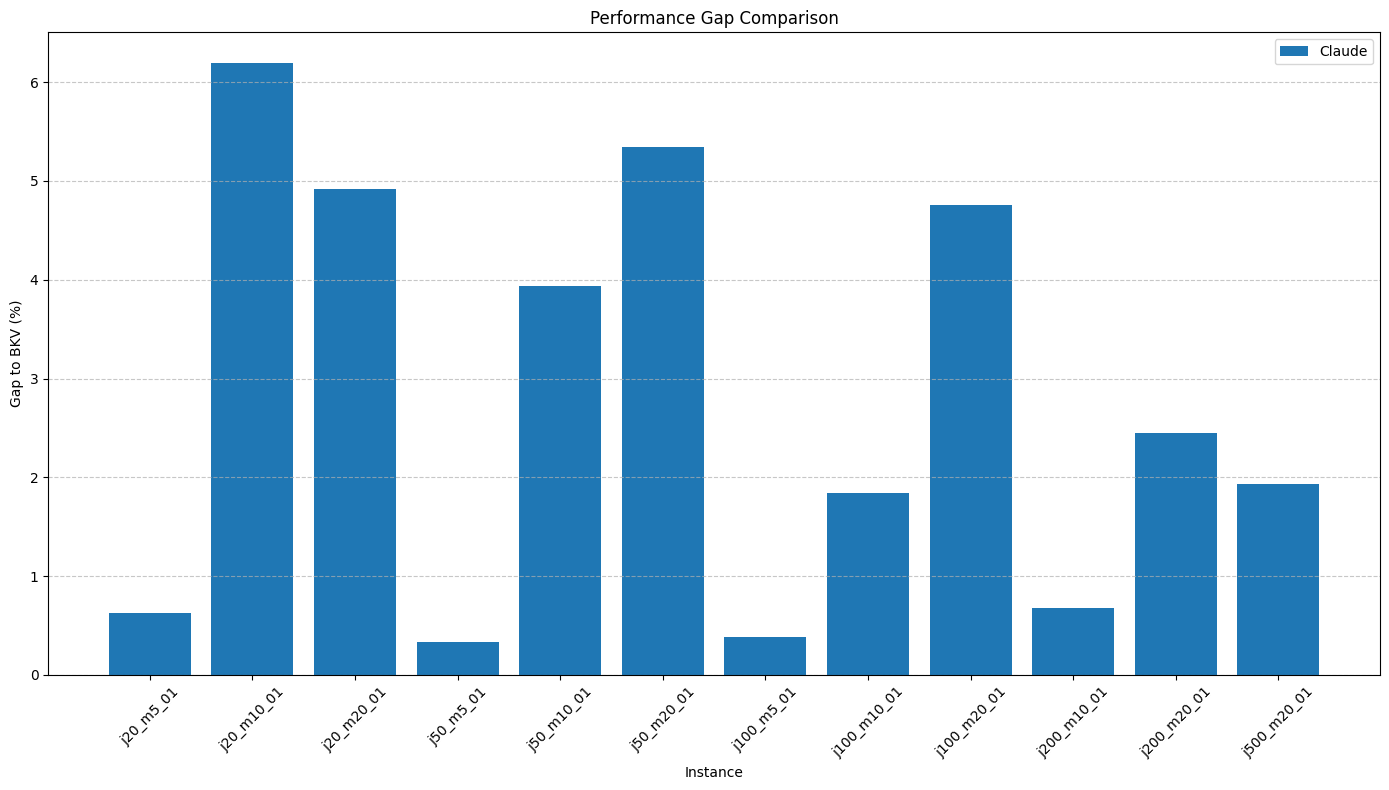

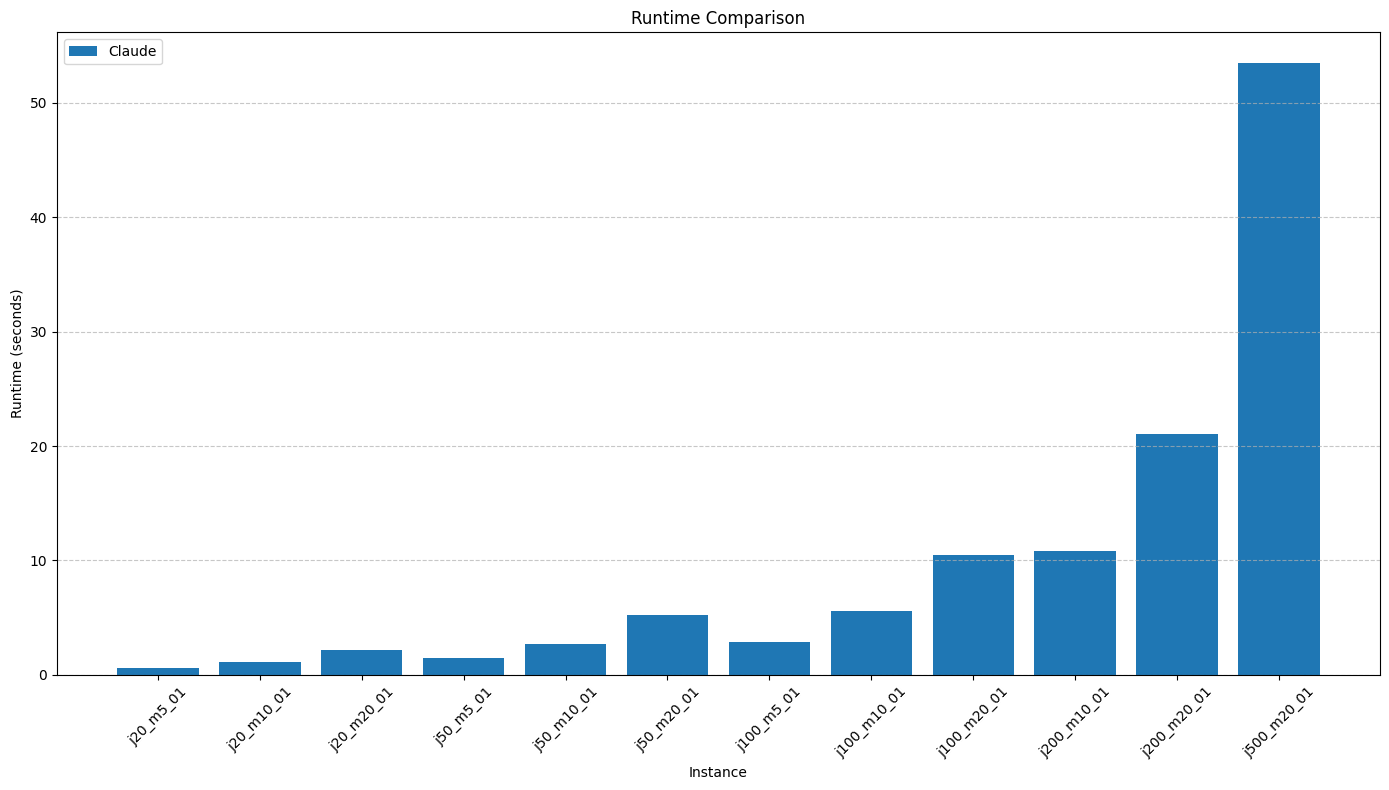

,Approach,Avg Gap (%),Best Gap (%),Worst Gap (%),Avg Time (s)
0,Claude,2.78265,0.330396,6.19469,9.792604


,Instance,Size,BKV,Claude_Obj,Claude_Gap,Claude_Time
0,j20_m5_01,20x5,1278,1286,0.625978,0.590787
1,j20_m10_01,20x10,1582,1680,6.194690,1.106058
2,j20_m20_01,20x20,2297,2410,4.919460,2.160210
3,j50_m5_01,50x5,2724,2733,0.330396,1.497465
4,j50_m10_01,50x10,3025,3144,3.933884,2.689089
5,j50_m20_01,50x20,3875,4082,5.341935,5.224828
6,j100_m5_01,100x5,5493,5514,0.382305,2.867877
7,j100_m10_01,100x10,5770,5876,1.837088,5.572970
8,j100_m20_01,100x20,6286,6585,4.756602,10.446572
9,j200_m10_01,200x10,10868,10942,0.680898,10.798539


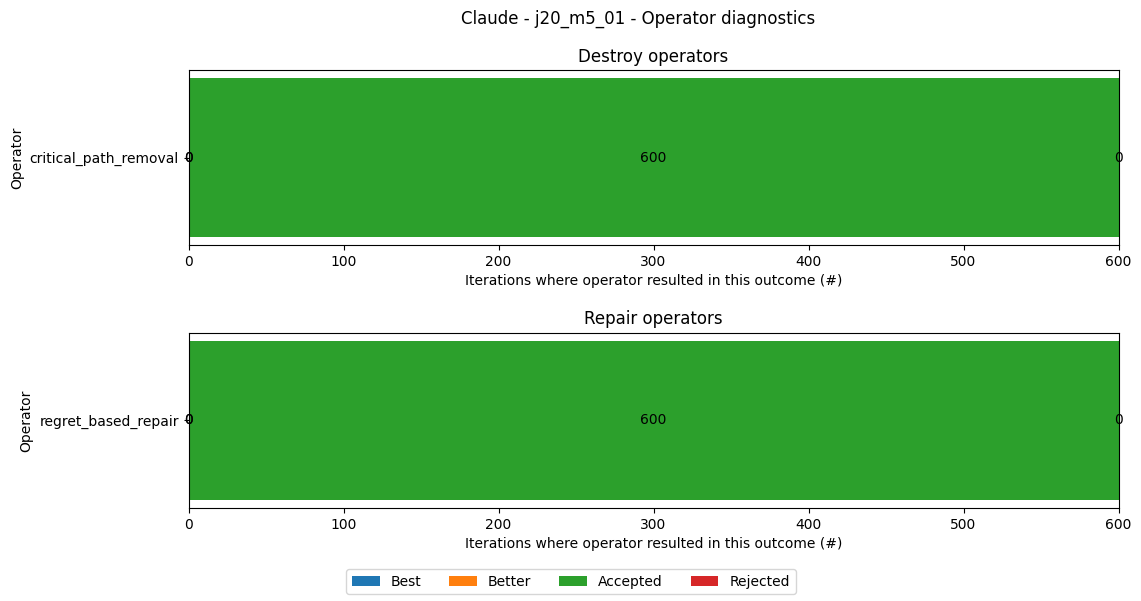

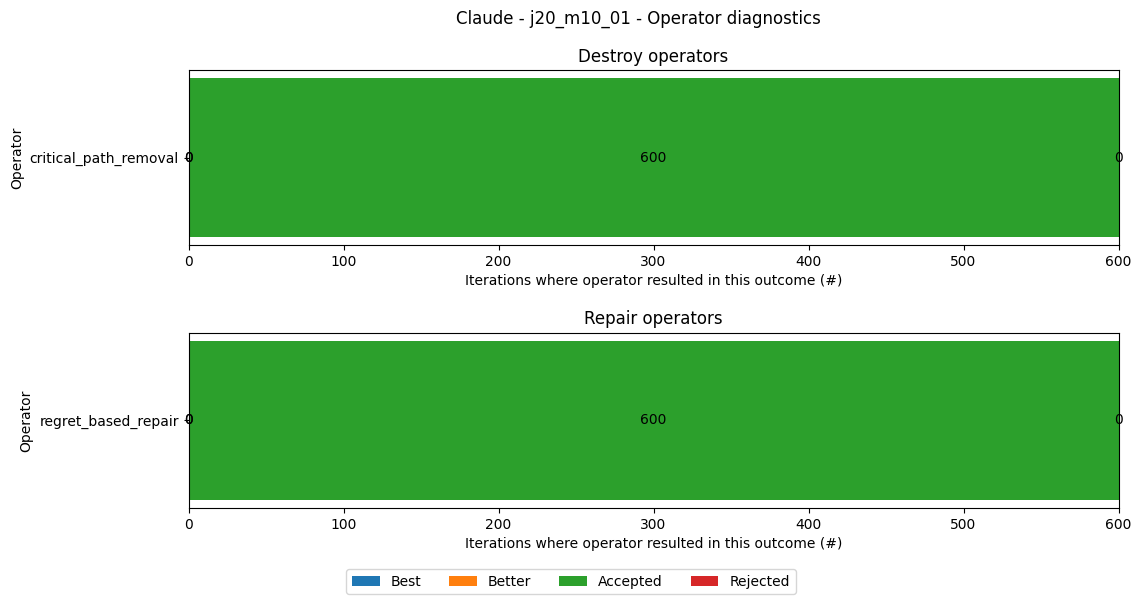

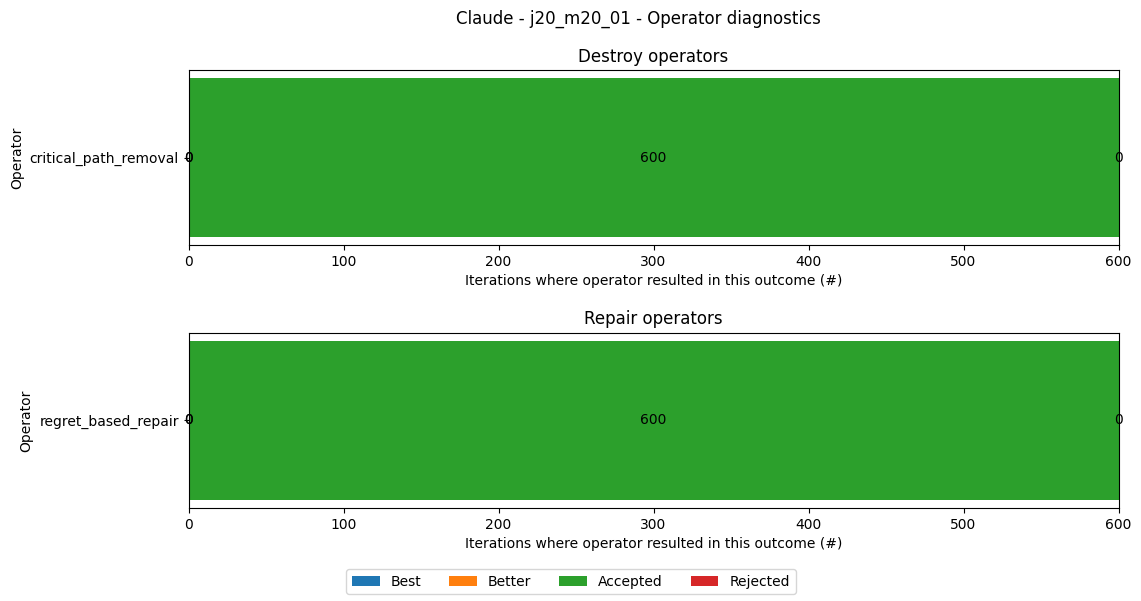

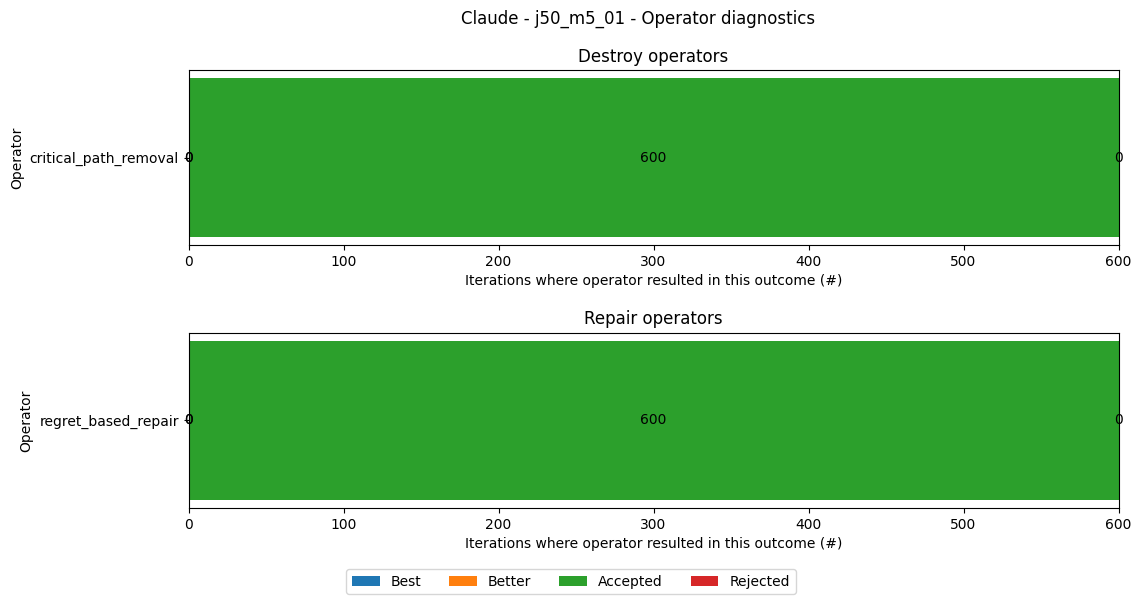

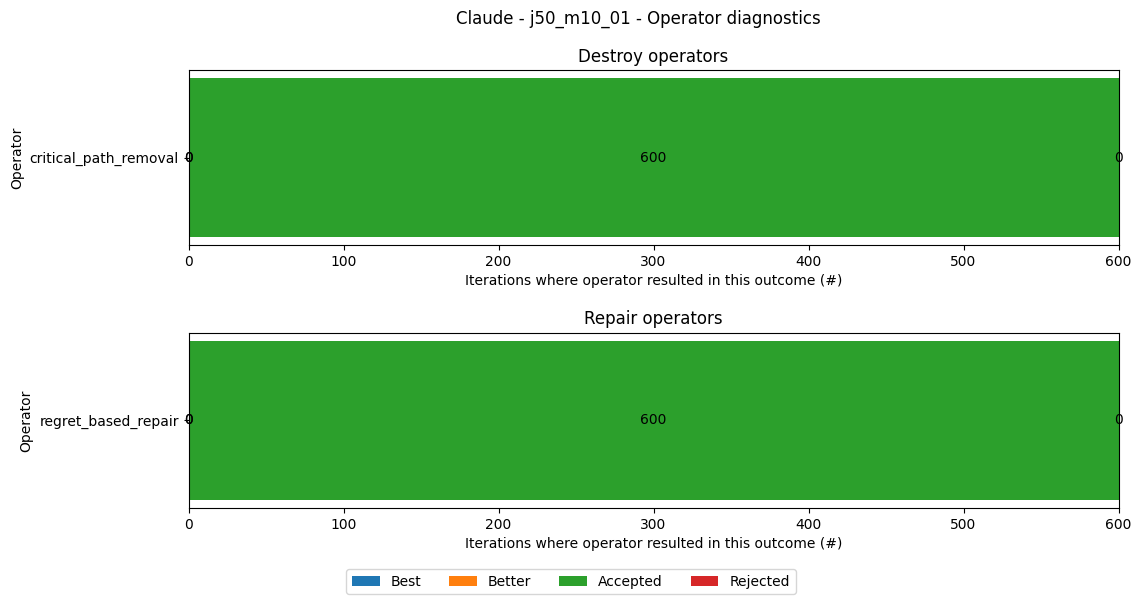

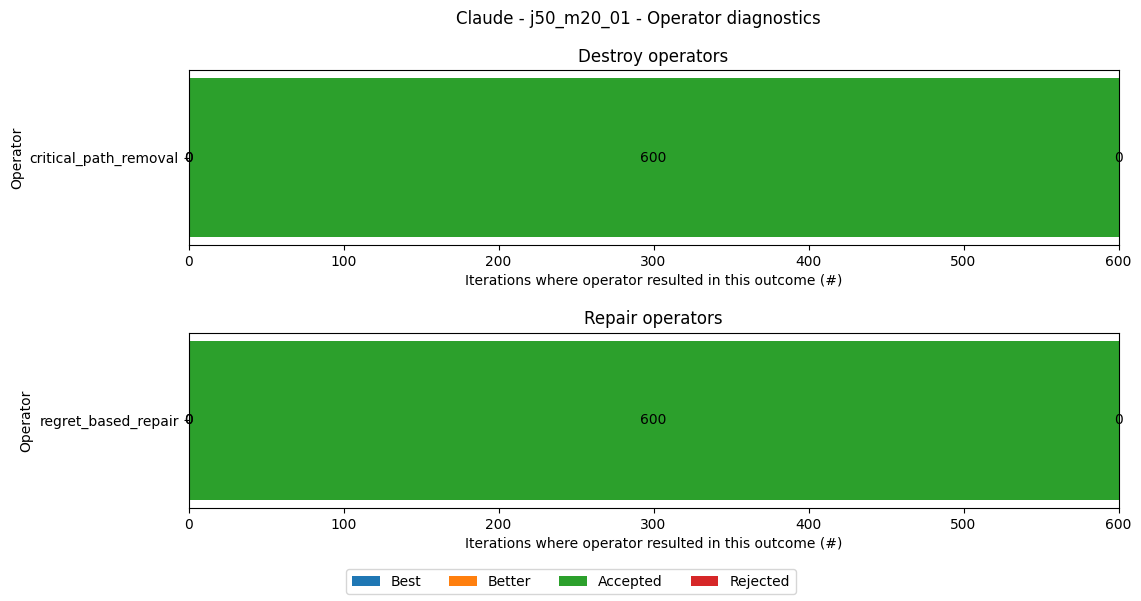

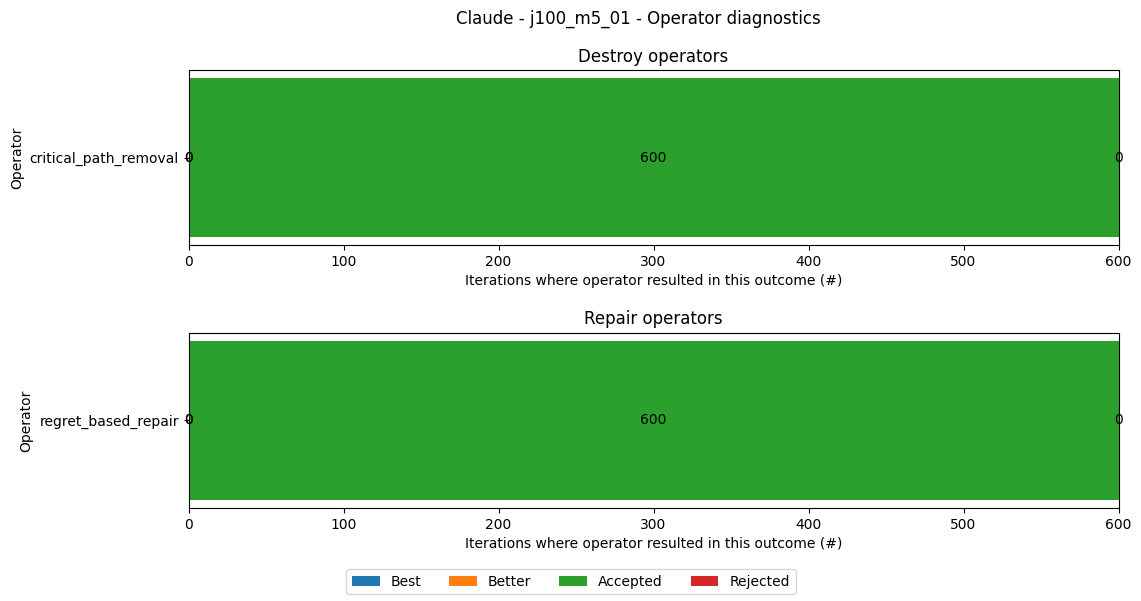

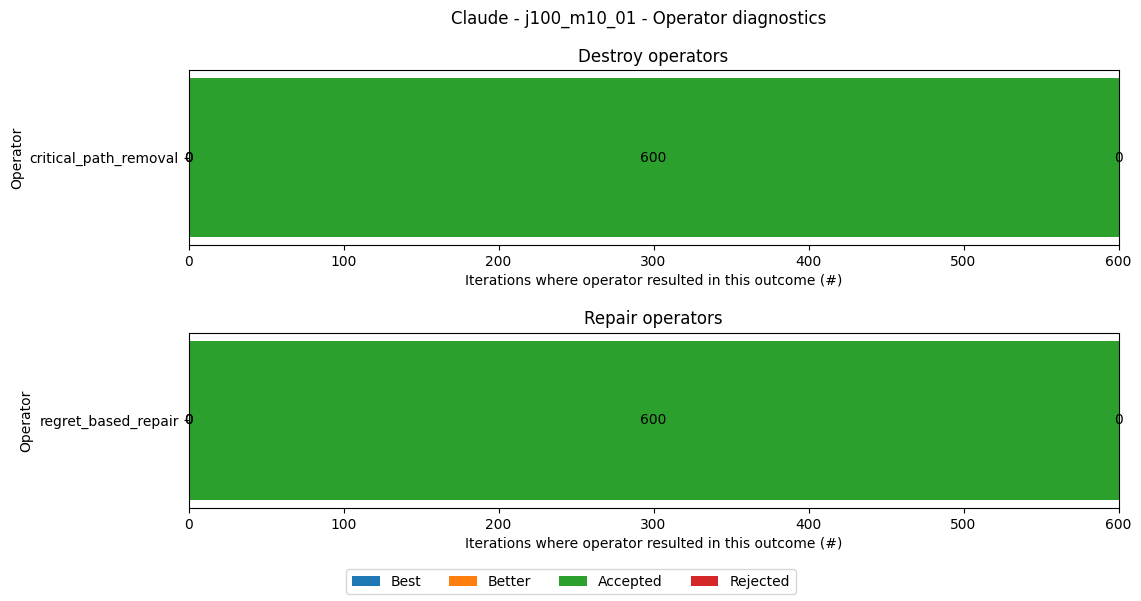

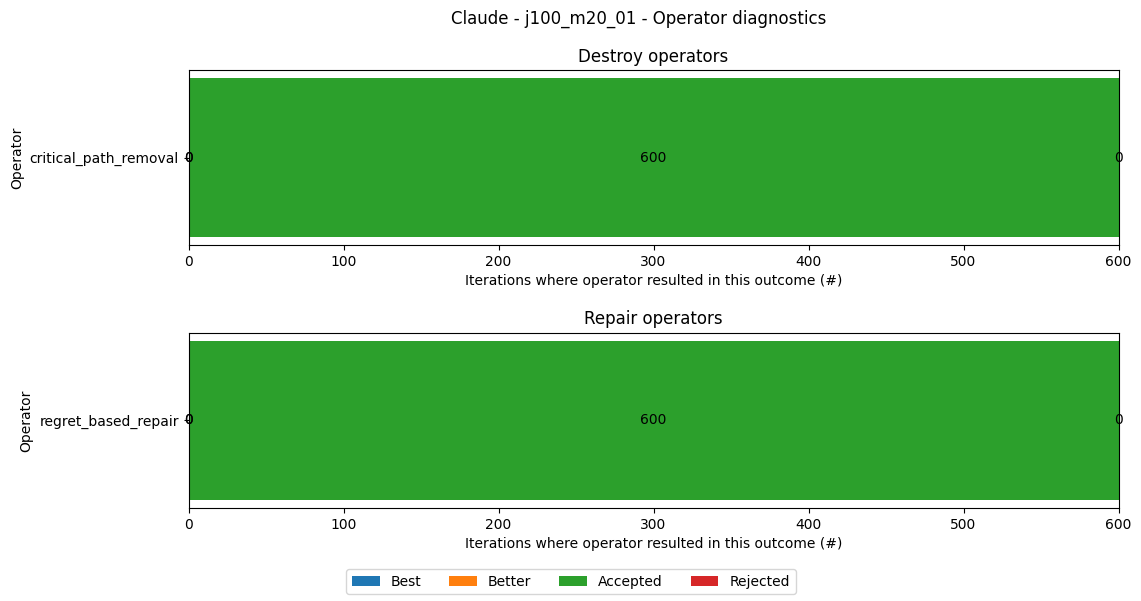

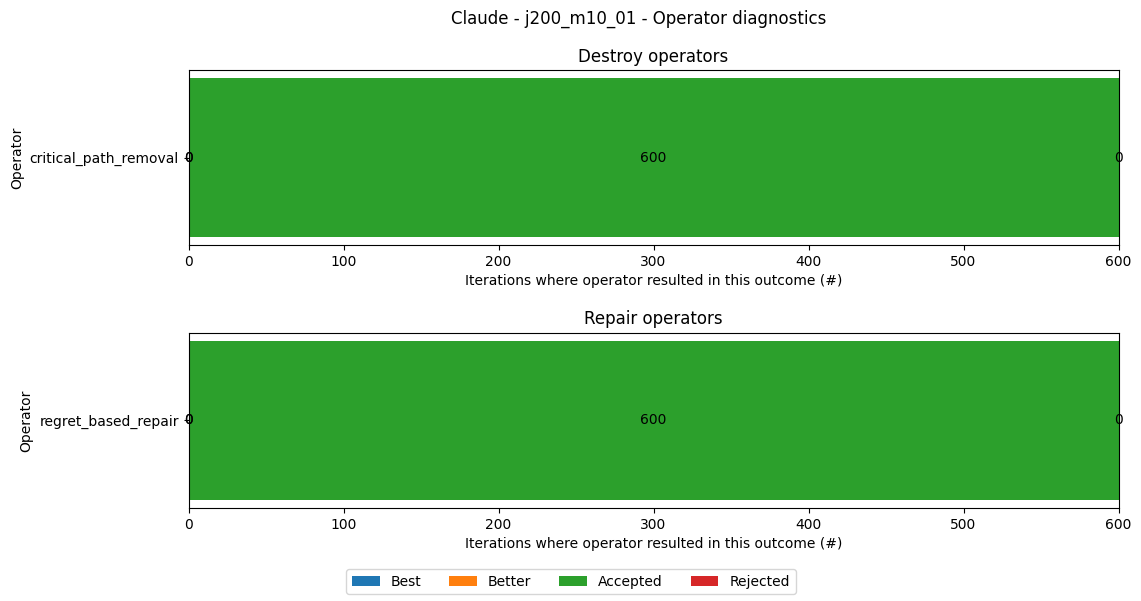

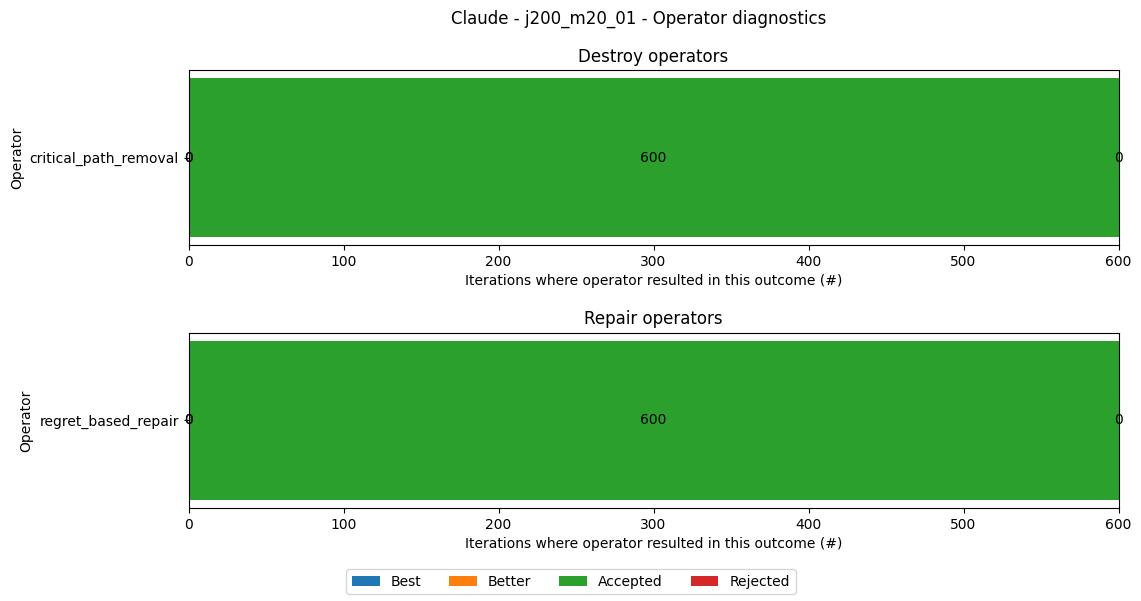

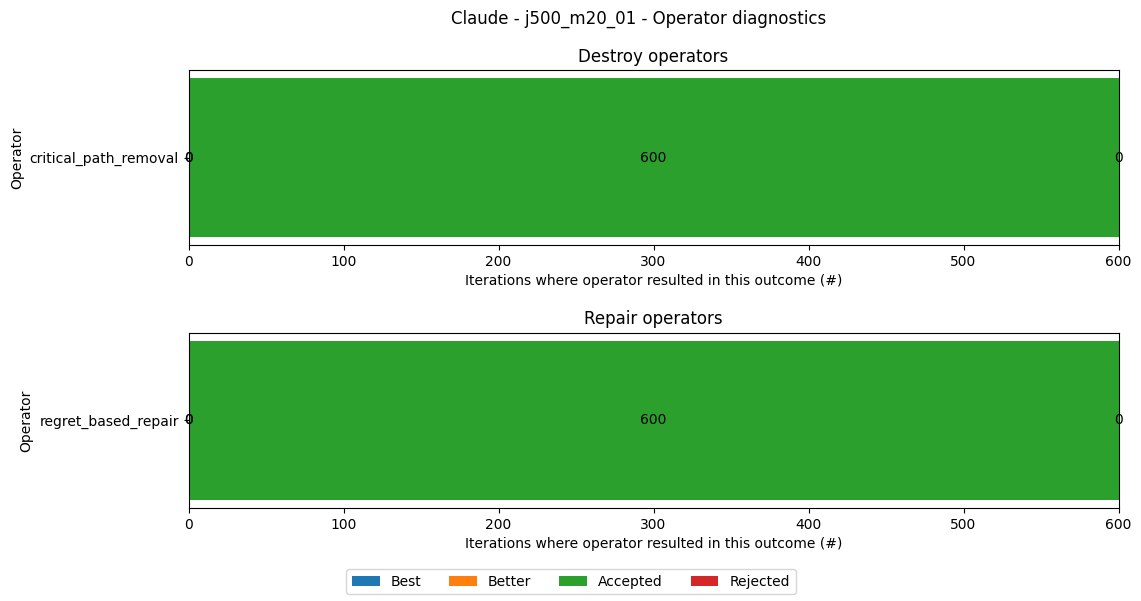

In [34]:
def run_benchmark(data_files, approaches, seed=SEED, iters=8000):
    """
    Benchmark different ALNS approaches on multiple problem instances.
    
    Args:
        data_files: List of paths to problem instance files
        approaches: Dictionary mapping approach names to lists of (destroy_ops, repair_ops)
        seed: Random seed for reproducibility
        iters: Number of iterations for each ALNS run
    
    Returns:
        Dictionary containing all benchmark results
    """
    results = {
        'instance_names': [],
        'instance_sizes': [],
        'best_known_values': [],
    }
    
    # Initialize results dictionary for each approach
    for approach_name in approaches:
        results[f'{approach_name}_objectives'] = []
        results[f'{approach_name}_gaps'] = []
        results[f'{approach_name}_times'] = []
        results[f'{approach_name}_results'] = []  # Store the ALNS result objects
    
    for data_file in data_files:
        # Extract instance name from file path
        instance_name = data_file.split('/')[-1].split('.')[0]
        print(f"\nProcessing instance: {instance_name}")
        
        # Load data
        data = Data.from_file(data_file)
        global DATA  # Use global DATA variable for the operators
        DATA = data
        
        results['instance_names'].append(instance_name)
        results['instance_sizes'].append(f"{data.n_jobs}x{data.n_machines}")
        results['best_known_values'].append(data.bkv)
        
        # Create initial solution using NEH
        init = NEH(data.processing_times)
        
        # Run each approach
        for approach_name, (destroy_ops, repair_ops) in approaches.items():
            print(f"  Running {approach_name}...")
            
            # Setup ALNS
            alns = ALNS(rnd.default_rng(seed))
            
            # Add destroy operators
            for destroy_op in destroy_ops:
                alns.add_destroy_operator(destroy_op)
            
            # Add repair operators
            for repair_op in repair_ops:
                alns.add_repair_operator(repair_op)
            
            # Configure ALNS parameters
            select = AlphaUCB(
                scores=[5, 2, 1, 0.5],
                alpha=0.05,
                num_destroy=len(alns.destroy_operators),
                num_repair=len(alns.repair_operators),
            )
            accept = SimulatedAnnealing.autofit(init.objective(), 0.05, 0.50, iters)
            stop = MaxIterations(iters)
            
            # Add time tracking
            time_stop = MaxRuntime(3600)  # 1 hour max runtime
            
            # Run ALNS
            start_time = time.time()
            result = alns.iterate(deepcopy(init), select, accept, stop)
            runtime = time.time() - start_time
            
            # Record results
            objective = result.best_state.objective()
            gap = 100 * (objective - data.bkv) / data.bkv
            
            results[f'{approach_name}_objectives'].append(objective)
            results[f'{approach_name}_gaps'].append(gap)
            results[f'{approach_name}_times'].append(runtime)
            results[f'{approach_name}_results'].append(result)  # Store the ALNS result object
            
            print(f"    Objective: {objective}, Gap: {gap:.2f}%, Time: {runtime:.2f}s")
    
    return results

def visualize_results(results):
    """
    Create visualizations to compare the approaches.
    """
    approach_names = [name.split('_')[0] for name in results.keys() 
                     if name.endswith('_objectives')]
    
    # Create a DataFrame for easier manipulation
    df = pd.DataFrame({
        'Instance': results['instance_names'],
        'Size': results['instance_sizes'],
        'BKV': results['best_known_values']
    })
    
    for approach in approach_names:
        df[f'{approach}_Obj'] = results[f'{approach}_objectives']
        df[f'{approach}_Gap'] = results[f'{approach}_gaps']
        df[f'{approach}_Time'] = results[f'{approach}_times']
    
    # 1. Gap comparison chart
    plt.figure(figsize=(14, 8))
    
    x = np.arange(len(df['Instance']))
    width = 0.8 / len(approach_names)
    
    for i, approach in enumerate(approach_names):
        plt.bar(x + i*width - 0.4 + width/2, df[f'{approach}_Gap'], 
                width=width, label=approach)
    
    plt.xlabel('Instance')
    plt.ylabel('Gap to BKV (%)')
    plt.title('Performance Gap Comparison')
    plt.xticks(x, df['Instance'], rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 2. Runtime comparison
    plt.figure(figsize=(14, 8))
    
    for i, approach in enumerate(approach_names):
        plt.bar(x + i*width - 0.4 + width/2, df[f'{approach}_Time'], 
                width=width, label=approach)
    
    plt.xlabel('Instance')
    plt.ylabel('Runtime (seconds)')
    plt.title('Runtime Comparison')
    plt.xticks(x, df['Instance'], rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 3. Summary table
    summary = pd.DataFrame({
        'Approach': approach_names,
        'Avg Gap (%)': [df[f'{approach}_Gap'].mean() for approach in approach_names],
        'Best Gap (%)': [df[f'{approach}_Gap'].min() for approach in approach_names],
        'Worst Gap (%)': [df[f'{approach}_Gap'].max() for approach in approach_names],
        'Avg Time (s)': [df[f'{approach}_Time'].mean() for approach in approach_names],
    })
    
    display(summary)
    
    # 4. Detailed results table
    display(df)
    
    # 5. Operator diagnostics for each approach and each instance
    for approach in approach_names:
        if f'{approach}_results' in results and results[f'{approach}_results']:
            for i, (instance_name, result) in enumerate(zip(results['instance_names'], results[f'{approach}_results'])):
                figure = plt.figure(f"{approach}_{instance_name}_operator_counts", figsize=(12, 6))
                figure.subplots_adjust(bottom=0.15, hspace=0.5)
                result.plot_operator_counts(figure, title=f"{approach} - {instance_name} - Operator diagnostics")
                plt.show()
    
    return df

if __name__ == "__main__":
    import time
    import pandas as pd
    
    # Define the approaches to compare
    approaches = {
        'Baseline': (
            [random_removal, adjacent_removal],  # destroy operators
            [greedy_repair]    # repair operators
        ),
        'Gemini': (
            [random_removal, adjacent_removal, worst_job_removal, related_job_removal],  # replace with your custom operators
            [regret_repair,min_idle_proxy_repair] # replace with your custom operators
        ),
        'Claude': (
            [critical_path_removal, bottleneck_machine_removal, makespan_contribution_removal, block_removal, worst_position_removal],  # replace with your custom operators
            [least_processing_time_repair, regret_insertion_repair, bottleneck_based_repair, random_insert_with_local_search, two_phase_insertion_repair] # replace with your custom operators
        )
    }
    
    # List all Taillard instances
    data_files = [
        "data/j20_m5/j20_m5_01.txt",
        "data/j20_m10/j20_m10_01.txt",
        "data/j20_m20/j20_m20_01.txt",
        "data/j50_m5/j50_m5_01.txt",
        "data/j50_m10/j50_m10_01.txt",
        "data/j50_m20/j50_m20_01.txt",
        "data/j100_m5/j100_m5_01.txt",
        "data/j100_m10/j100_m10_01.txt",
        "data/j100_m20/j100_m20_01.txt",
        "data/j200_m10/j200_m10_01.txt",
        "data/j200_m20/j200_m20_01.txt",
        "data/j500_m20/j500_m20_01.txt",
    ]
    
    # Run the benchmark
    results = run_benchmark(data_files, approaches, seed=SEED, iters=600)
    
    # Visualize and analyze the results
    results_df = visualize_results(results)
    
    # Save results to CSV
    results_df.to_csv('alns_operator_selection_results.csv', index=False)